<a href="https://colab.research.google.com/github/engineercha/engineercha/blob/master/%EC%A1%B8%ED%94%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1)데이터 불러오기

In [1]:
from scipy import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')
file_path = "/content/gdrive/My Drive/Colab Notebooks/data/vibration/vibration/"

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
global N, Fs, T
N=2000000
Fs=200000
T=10

## 2)데이터 구조 살피기

각 데이터에는 2개의 채널이 있습니다. 채널1은 가속도계에 의해 측정된 진동 데이터, 채널2는 인코더에 의해 측정된 회전속도 데이터입니다.

In [ ]:
mat_file = io.loadmat(file_path+'H-A-1.mat')
mat_file

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Oct 09 15:18:50 2018',
 '__version__': '1.0',
 '__globals__': [],
 'Channel_1': array([[-0.00219944],
        [-0.0018706 ],
        [-0.00154175],
        ...,
        [ 0.00963905],
        [ 0.0093102 ],
        [ 0.00898136]]),
 'Channel_2': array([[4.18876708],
        [4.20060302],
        [4.20816487],
        ...,
        [0.03700339],
        [0.03634584],
        [4.14010822]])}

## 3) 데이터 전처리

In [4]:
raw=[]
aug=[]
file_names=['H-A-1.mat','H-A-2.mat','H-A-3.mat','H-B-1.mat','H-B-2.mat','H-B-3.mat','H-C-1.mat','H-C-2.mat','H-C-3.mat','H-D-1.mat','H-D-2.mat','H-D-3.mat','I-A-1.mat','I-A-2.mat','I-A-3.mat','I-B-1.mat','I-B-2.mat','I-B-3.mat','I-C-1.mat','I-C-2.mat','I-C-3.mat','I-D-1.mat','I-D-2.mat','I-D-3.mat','O-A-1.mat','O-A-2.mat','O-A-3.mat','O-B-1.mat','O-B-2.mat','O-B-3.mat','O-C-1.mat','O-C-2.mat','O-C-3.mat','O-D-1.mat','O-D-2.mat','O-D-3.mat','B-A-1.mat','B-A-2.mat','B-A-3.mat','B-B-1.mat','B-B-2.mat','B-B-3.mat','B-C-1.mat','B-C-2.mat','B-C-3.mat','B-D-1.mat','B-D-2.mat','B-D-3.mat', 'C-A-1.mat','C-A-2.mat','C-A-3.mat','C-B-1.mat','C-B-2.mat','C-B-3.mat','C-C-1.mat','C-C-2.mat','C-C-3.mat','C-D-1.mat','C-D-2.mat','C-D-3.mat']

for i in range(60):
  mat_file = io.loadmat(file_path+file_names[i])['Channel_1']
  raw.append(mat_file)
  for j in range(1000):
    aug.append(mat_file[2000*j:2000*(j+1)])

raw=np.array(raw).reshape(60,2000000)
aug=np.array(aug).reshape(60000,2000)

#길이가 200만인 1개의 데이터를 길이가 2천인 1000개의 데이터로 분할함
#기존의 데이터는 10초동안 측정된 데이터이므로 분할된 데이터는 1/100초에 해당함

In [7]:
raw_fft=[]

for i in range(60):
  fft=np.fft.fft(raw[i])/N
  raw_fft.append(fft)

raw_fft=np.array(raw_fft)

In [5]:
aug_fft=[]

for i in range(60000):
  fft=np.fft.fft(aug[i])/2000
  aug_fft.append(fft[:1000])

aug_fft=np.array(aug_fft)

# 신호를 np.fft.fft() 함수로 푸리에 변환한다. 이때, 함수의 반환값을 신호의 길이로 나누어 normalization 해주어야 한다.
# magnitude를 얻기 위해 함수의 반환값에 abs()를 취한다.
# 푸리에 변환을 통해 주파수에 따른 magnitude와 angle을 구할 수 있는데, 반환값이 복소수 타입이기 때문이다.
# fft한 결과는 좌우대칭하므로 left에 해당하는 부분만 idexing 하여 데이터 크기를 줄인다.

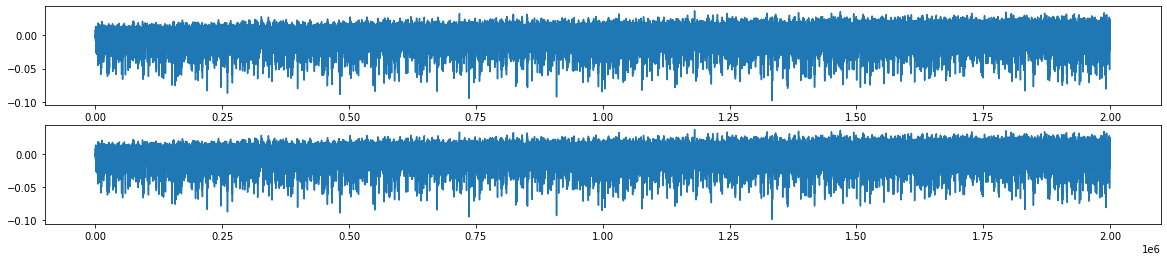

In [ ]:
plt.figure(figsize=(20,4))
plt.subplot(2,1,1); plt.plot(raw[0]);
plt.subplot(2,1,2); plt.plot(np.hstack(aug[0:1000]));
plt.show()

## 4)학습

- precision(정밀도) = TP/(TP+FP) = 정상예측 중 실제정상의 비율 => FP가 많을 수록 정밀도가 낮아짐
- recall(재현율) = TP/(TP+FN) = 실제정상 중 정상예측의 비율

In [8]:
x=pd.DataFrame(abs(aug_fft))
y=np.concatenate([np.ones(12000, int), np.zeros(48000, int)]) #정상은 1, 고장은 0
df=x
df['class']=y

#### 참고

회귀 모델에 fft 데이터를 사용한다면 속도에 따른 y 변화를 고려해 스케일링 할 필요가 없음을 증명

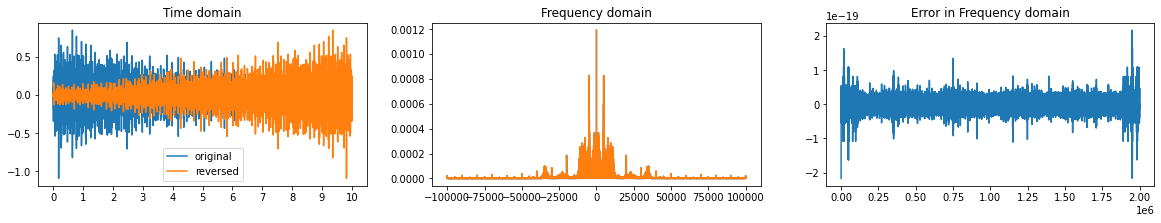

In [8]:
plt.figure(figsize=(20,3))
plt.subplot(1,3,1)
plt.title("Time domain")
plt.plot(raw[15]); plt.plot(raw[15][::-1])
plt.legend(['original', 'reversed'])
plt.xticks([0,200000,400000,600000,800000,1000000,1200000,1400000,1600000,1800000,2000000], [0,1,2,3,4,5,6,7,8,9,10])

plt.subplot(1,3,2)
plt.title("Frequency domain")
freq=np.fft.fftfreq(N, 1/Fs)
org=abs(raw_fft[15])
rev=abs(np.fft.fft(raw[15][::-1])/N)
plt.plot(freq, org); plt.plot(freq, rev)

plt.subplot(1,3,3)
plt.title("Error in Frequency domain")
plt.plot(org-rev)

#time domain에는 시간에 따라 y가 증가하는 데이터와 감소하는 데이터가 있다.
#따라서 감소하는 데이터를 좌우반전하여 증가하는 진동데이터로 만들어도, fft을 한 결과는 동일하다.
#frequency domain에서 최대 2.1684 e-19의 오차는 존재한다.

#### 선형회귀 모델(16)

keras로 구현한 회귀 알고리즘

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [102]:
train_dataset = df.sample(frac=0.8, random_state=0) #sample을 사용하여 데이터셋을 train과 test로 분할함
test_dataset = df.drop(train_dataset.index)
train_labels = train_dataset.pop('class') #pop을 사용하여 label에 해당하는 class cloumn을 제거하고 새로운 변수에 저장함
test_labels = test_dataset.pop('class')

In [103]:
train_stats = train_dataset.describe().transpose()
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
0,48000.0,0.004864,0.026548,4.940247e-08,0.000570,0.001200,0.002049,0.250876
1,48000.0,0.001286,0.000824,5.734480e-06,0.000680,0.001114,0.001713,0.007403
2,48000.0,0.001557,0.001112,5.116033e-06,0.000739,0.001259,0.002106,0.009634
3,48000.0,0.000684,0.000515,3.153886e-06,0.000325,0.000544,0.000894,0.005996
4,48000.0,0.000589,0.000461,1.772341e-06,0.000266,0.000461,0.000780,0.006405


In [104]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset) #feature들의 스케일과 범위가 다르면 정규화해야 함
normed_test_data = norm(test_dataset)

In [105]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse']) #평균절대오차와 평균제곱오차
  return model

In [106]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 32)                32032     
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 34,209
Trainable params: 34,209
Non-trainable params: 0
_________________________________________________________________


In [107]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

history = model.fit(normed_train_data, train_labels, epochs=500, 
                    validation_split = 0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [110]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  plt.figure(figsize=(10,4))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
  plt.ylim([0,0.06])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
  plt.ylim([0,0.025])
  plt.legend()
  plt.show()

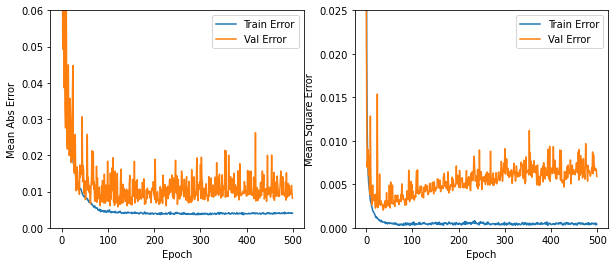

In [111]:
plot_history(history)


......................

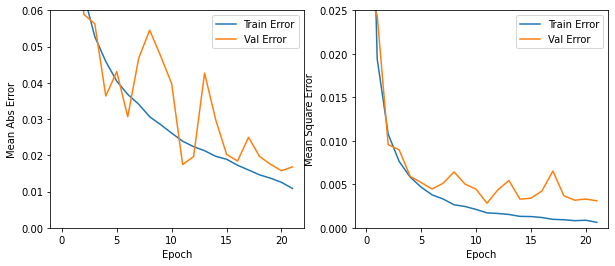

In [112]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model = build_model()
history = model.fit(normed_train_data, train_labels, epochs=500,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

평균적으로 epochs가 25에서 early stopping함

In [113]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print() 
print("◎ 테스트 세트의 평균 절대 오차: {:5.4f}".format(mae))

375/375 - 1s - loss: 0.0036 - mae: 0.0174 - mse: 0.0036 - 549ms/epoch - 1ms/step

◎ 테스트 세트의 평균 절대 오차: 0.0174


375/375 [==============================] - 1s 2ms/step


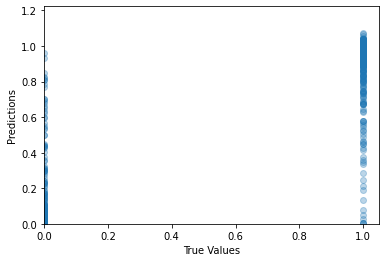

In [114]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.show()

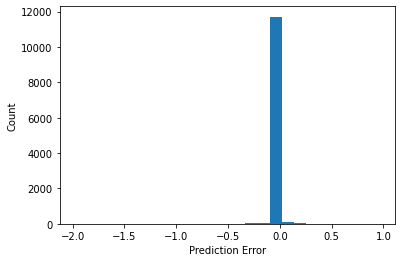

In [115]:
error = test_predictions - test_labels

plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.show()

선형회귀에 적합한 데이터가 아니기 때문에 오차를 구하는 것은 의미가 없음

In [116]:
pred=np.array([0 if i<0.5 else 1 for i in list(test_predictions)])
print(confusion_matrix(test_labels, pred))
print()
print("◎ 테스트 세트의 정확도: {:5.4f}".format(metrics.accuracy_score(test_labels, pred)))
print("◎ 테스트 세트의 정밀도: {:5.4f}".format(metrics.precision_score(test_labels, pred)))
print("◎ 테스트 세트의 재현율: {:5.4f}".format(metrics.recall_score(test_labels, pred)))
print("◎ 테스트 세트의 정밀도와 재현율의 조화평균: {:5.4f}".format(metrics.f1_score(test_labels, pred)))

[[9577   23]
 [  23 2377]]

◎ 테스트 세트의 정확도: 0.9962
◎ 테스트 세트의 정밀도: 0.9904
◎ 테스트 세트의 재현율: 0.9904
◎ 테스트 세트의 정밀도와 재현율의 조화평균: 0.9904


#### 로지스틱 회귀 모델(실패)

scikit-learn으로 구현한 분류 알고리즘

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

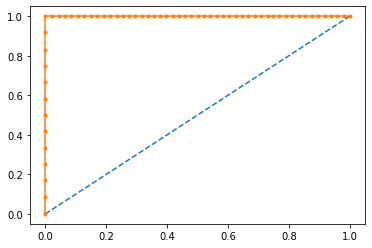

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='class'], df['class'], random_state=1)

scaler=StandardScaler()
x_train, x_test=scaler.fit_transform(X_train), scaler.transform(X_test)

clf=LogisticRegression()
clf.fit(x_train, y_train)

pred=clf.predict(x_test)
prob=clf.predict_proba(x_test)

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prob[:,1])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()


In [ ]:
confusion_matrix(y_test, pred)

array([[12028,     0],
       [    0,  2972]])

크기가 784인 이미지와 실제 숫자값을 갖는 데이터가 7만개인 mnist와 비슷하게

크기가 1000인 신호와 실제 정상여부 값을 갖는 데이터 6만개


In [ ]:
df['class'].value_counts()

0    48000
1    12000
Name: class, dtype: int64

#### 딥러닝 모델

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns!='class'], df['class'], random_state=1)

model=Sequential()
model.add(Dense(800, input_dim=1000, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid')) #이진분류에 가장 많이 사용되는 활성화함수

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
list(y_train).count(1)+list(y_test).count(1)

12000

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 800)               800800    
                                                                 
 dense_41 (Dense)            (None, 250)               200250    
                                                                 
 dense_42 (Dense)            (None, 10)                2510      
                                                                 
 dense_43 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,003,571
Trainable params: 1,003,571
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(X_train, y_train, validation_split=0.25, epochs=20, batch_size=600)

Epoch 1/20
57/57 [==============================] - 5s 75ms/step - loss: 0.5056 - accuracy: 0.7999 - val_loss: 0.4418 - val_accuracy: 0.8028
Epoch 2/20
57/57 [==============================] - 4s 71ms/step - loss: 0.3762 - accuracy: 0.8029 - val_loss: 0.3074 - val_accuracy: 0.8028
Epoch 3/20
57/57 [==============================] - 4s 70ms/step - loss: 0.2399 - accuracy: 0.8988 - val_loss: 0.1911 - val_accuracy: 0.8990
Epoch 4/20
57/57 [==============================] - 4s 71ms/step - loss: 0.1295 - accuracy: 0.9783 - val_loss: 0.0816 - val_accuracy: 0.9898
Epoch 5/20
57/57 [==============================] - 4s 70ms/step - loss: 0.0484 - accuracy: 0.9921 - val_loss: 0.0289 - val_accuracy: 0.9925
Epoch 6/20
57/57 [==============================] - 4s 71ms/step - loss: 0.0258 - accuracy: 0.9935 - val_loss: 0.0300 - val_accuracy: 0.9902
Epoch 7/20
57/57 [==============================] - 4s 71ms/step - loss: 0.0181 - accuracy: 0.9948 - val_loss: 0.0169 - val_accuracy: 0.9953
Epoch 8/20
57

## 5)정확도, 정밀도 계산

In [62]:
def acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  #plt.title('Model accuracy')
  #plt.xlabel('Epoch')
  #plt.ylabel('Accuracy')
  plt.ylim(0.98,1)
  plt.legend(['Train', 'Validation'], loc='upper left')

def loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  #plt.ylim(0.98,1)
  plt.legend(['Train', 'Validation'], loc='upper left')

def res(model):
  pred=model.predict(X_test)
  pred=np.array([0 if i<0.5 else 1 for i in pred])
  print(confusion_matrix(y_test, pred))
  print(model.evaluate(X_test, y_test))
  print(metrics.precision_score(y_test, pred)) #정밀도를 계산해주는 메서드
  return pred

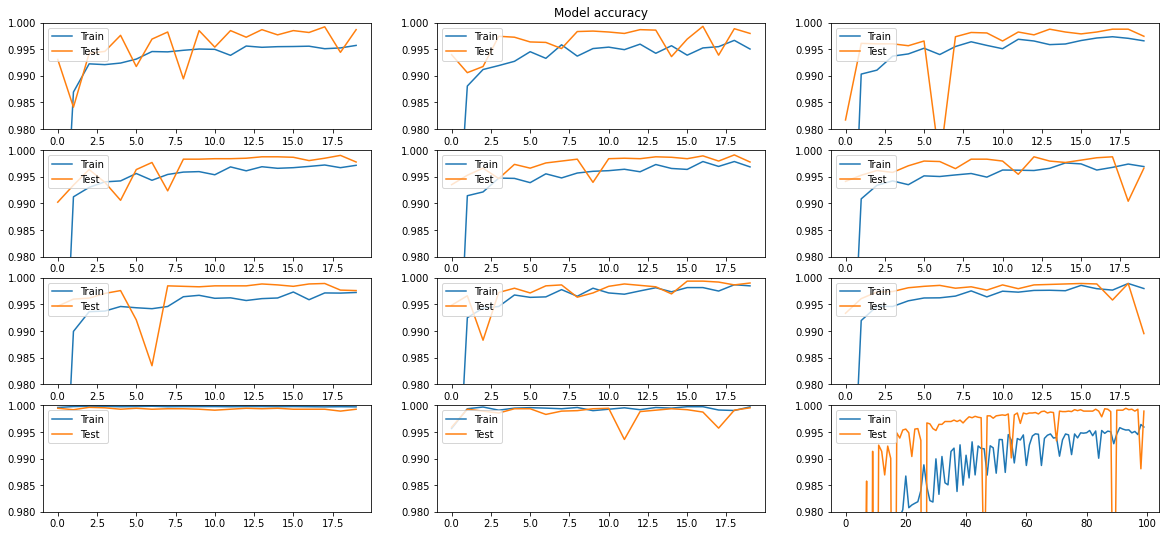

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(4,3,1); acc(history1)
plt.subplot(4,3,2); acc(history2); plt.title('Model accuracy')
plt.subplot(4,3,3); acc(history3)
plt.subplot(4,3,4); acc(history4)
plt.subplot(4,3,5); acc(history5)
plt.subplot(4,3,6); acc(history6)
plt.subplot(4,3,7); acc(history7)
plt.subplot(4,3,8); acc(history8)
plt.subplot(4,3,9); acc(history9)
plt.subplot(4,3,10); acc(history10)
plt.subplot(4,3,11); acc(history11)
plt.subplot(4,3,12); acc(history12)

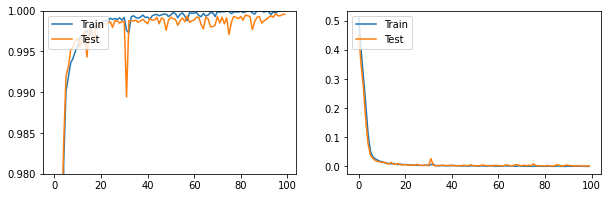

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); acc(history)
plt.subplot(1,2,2); loss(history)

나와 비슷한 케이스 https://datascience.stackexchange.com/questions/111264/how-to-analyse-the-accuracy-and-loss-graphs-of-model-history

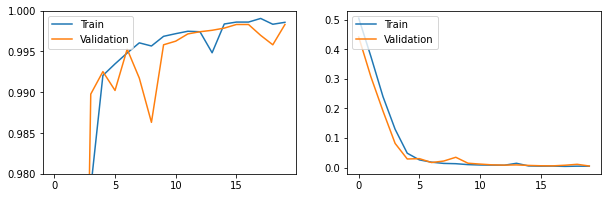

In [ ]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1); acc(history)
plt.subplot(1,2,2); loss(history)

In [ ]:
pred=res(model)

#confusion matrix의 구조는 TN(고장예측 실제고장), FP(정상예측 실제고장)
#                          FN(고장예측 실제정상), TP(정상예측 실제정상)
#고장을 정상으로 잘못 예측한 경우가 많다. 이러면 의미가 없다.

469/469 [==============================] - 2s 5ms/step
[[11858    12]
 [    9  3121]]
469/469 [==============================] - 3s 5ms/step - loss: 0.0043 - accuracy: 0.9986
[0.0042818812653422356, 0.9986000061035156]
0.9971246006389777


In [ ]:
temp=list(y_test)
print(temp.count(0), temp.count(1))

11870 3130


## 6)오분류 시각화

In [ ]:
def wrong(F_):
  plt.figure(figsize=(24,4))
  for i in range(len(F_)):
    idx=F_[i]
    plt.subplot(1,len(F_),i+1)
    plt.plot(abs(aug_fft[idx]))
    a=list(y_test)[idx]
    b=list(pred)[idx]
    plt.title(str(a)+'(predict:'+str(b)+')', color="red")

In [ ]:
FP=[i for i in range(15000) if list(y_test)[i]==0 and list(pred)[i]==1]

In [ ]:
FN=[i for i in range(15000) if list(y_test)[i]==1 and list(pred)[i]==0]

[3031, 7234, 7975]

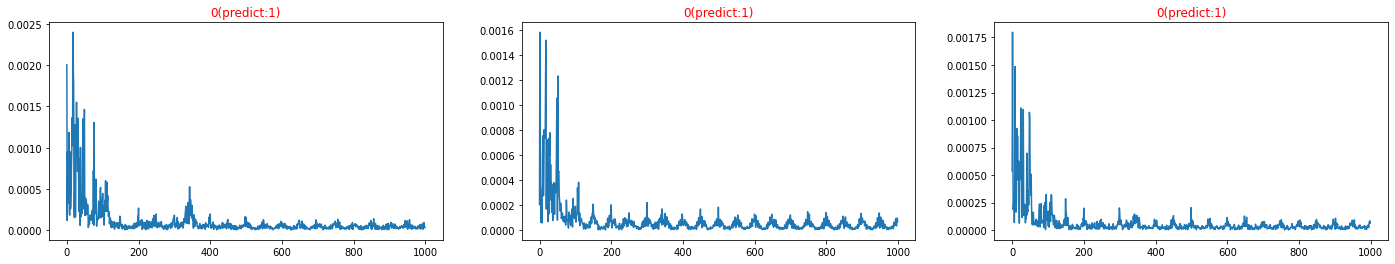

In [ ]:
wrong(FP); FP

[187, 1504, 1531, 2574, 2812, 10463, 10674, 11038, 12840, 13421, 13758]

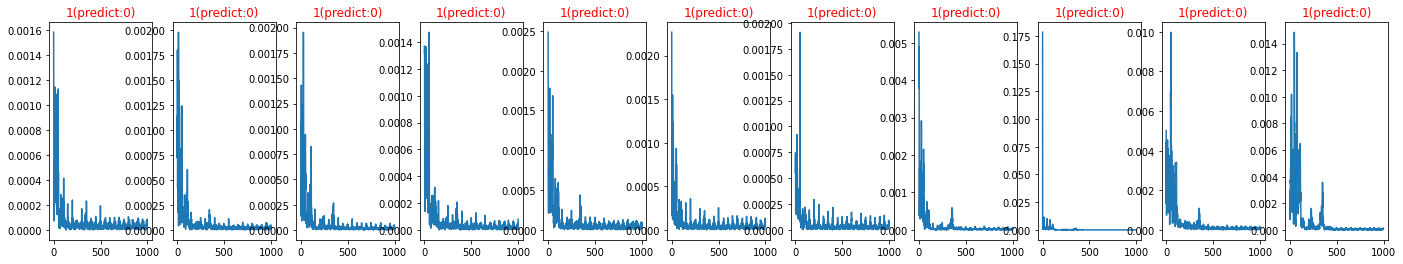

In [ ]:
wrong(FN); FN

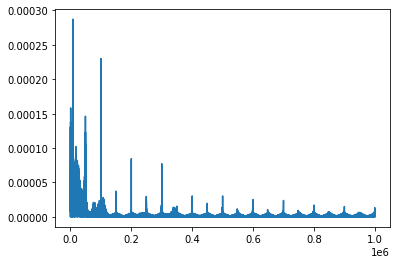

In [ ]:
mat_file=io.loadmat(file_path+'H-C-3.mat')['Channel_1'].reshape(N) #3031번째 aug data의 raw data
mat_fft=(np.fft.fft(mat_file)/N)[:N//2]
plt.plot(abs(mat_fft))

## STFT(short-time fourier transform)

In [ ]:
!pip install librosa

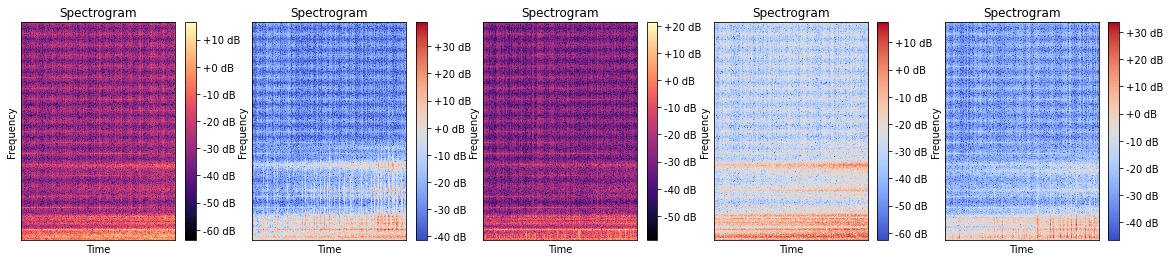

In [ ]:
sc=2

plt.figure(figsize=(20,4))
for i in range(5):
  plt.subplot(1,5,i+1)
  magnitude = np.abs(librosa.stft(raw[sc+12*i])) #순서대로 정상 베어링과 inner race, outer race, ball, combinnation 결함이 있는 베어링의 진동 데이터
  log_spectrogram = librosa.amplitude_to_db(magnitude)
  librosa.display.specshow(log_spectrogram, sr=Fs)
  plt.xlabel("Time")
  plt.ylabel("Frequency")
  plt.colorbar(format="%+2.0f dB")
  plt.title("Spectrogram")

#sc은 속도 조건을 선택하는 변수임
#0,1,2이면 증가, 3,4,5면 감소, 6,7,8이면 증가후감소, 9,10,11이면 감소후증가

In [ ]:
raw_stft=[]
for i in range(60):
  raw_stft.append(np.abs(librosa.stft(raw[i])))
  for j in range(1025):
    raw_stft[i][j]=( raw_stft[i][j]-raw_stft[i][j].min() )/( raw_stft[i][j].max()-raw_stft[i][j].min() )

In [ ]:
from scipy import signal

def draw_stft(f, t, Zxx):
    plt.figure(figsize=(12,5))
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
    plt.title('STFT Magnitude'); plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]'); plt.ylim([0, 100000]); plt.show()

def stft(data, x):
  f,t,Zxx=signal.stft(data, fs=200000, nperseg=x)
  draw_stft(f,t,Zxx)

# Fs=sampling frequency
# window size를 0.1s로 하려면 nperseg를 Fs*0.1로 설정하면 됨

In [ ]:
f,t,Zxx=signal.stft(raw[0], fs=200000, nperseg=1000)

## 7)시각화

#### 베어링 상태별 그래프

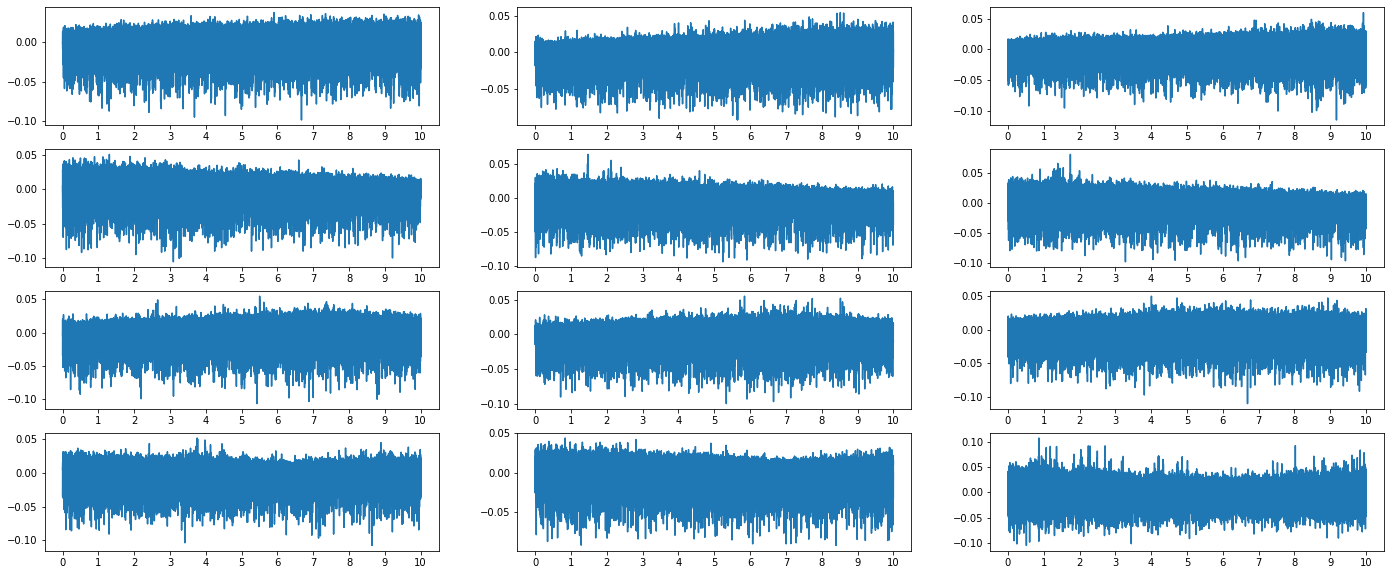

In [ ]:
#healthy bearing

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i])
  #plt.xticks([0,200000,400000,600000,800000,1000000,1200000,1400000,1600000,1800000,2000000], [0,1,2,3,4,5,6,7,8,9,10])
  #plt.xlabel('time(s)')

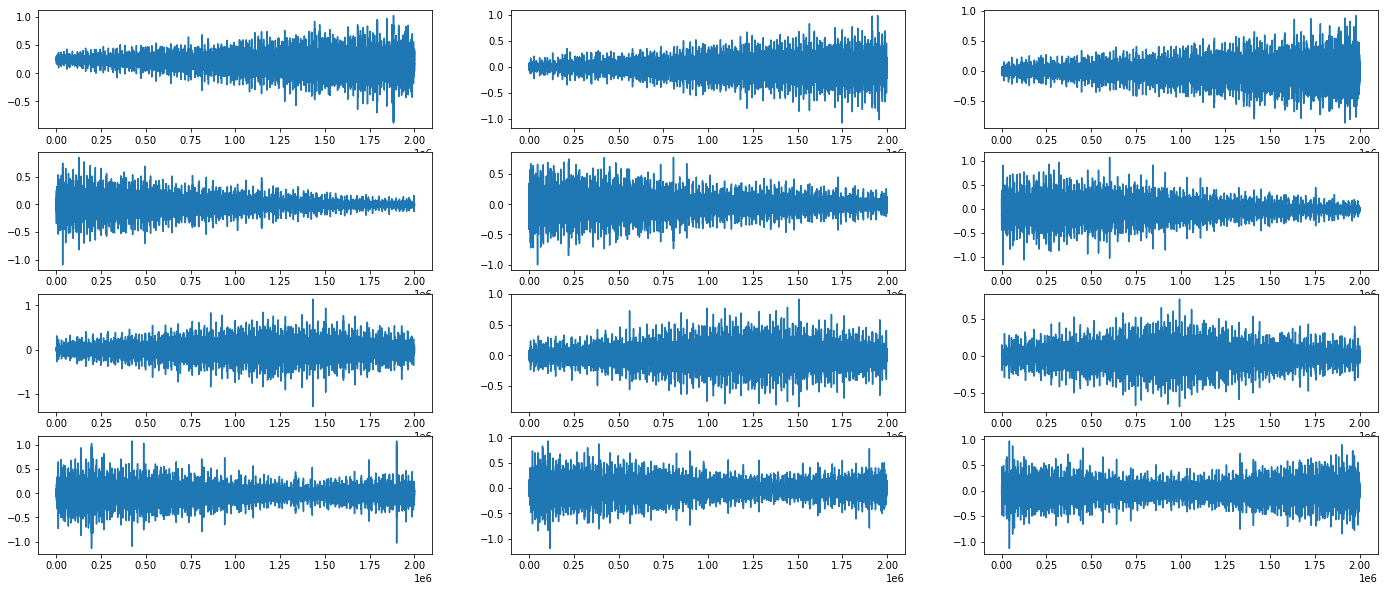

In [ ]:
#inner race fault 

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+12])

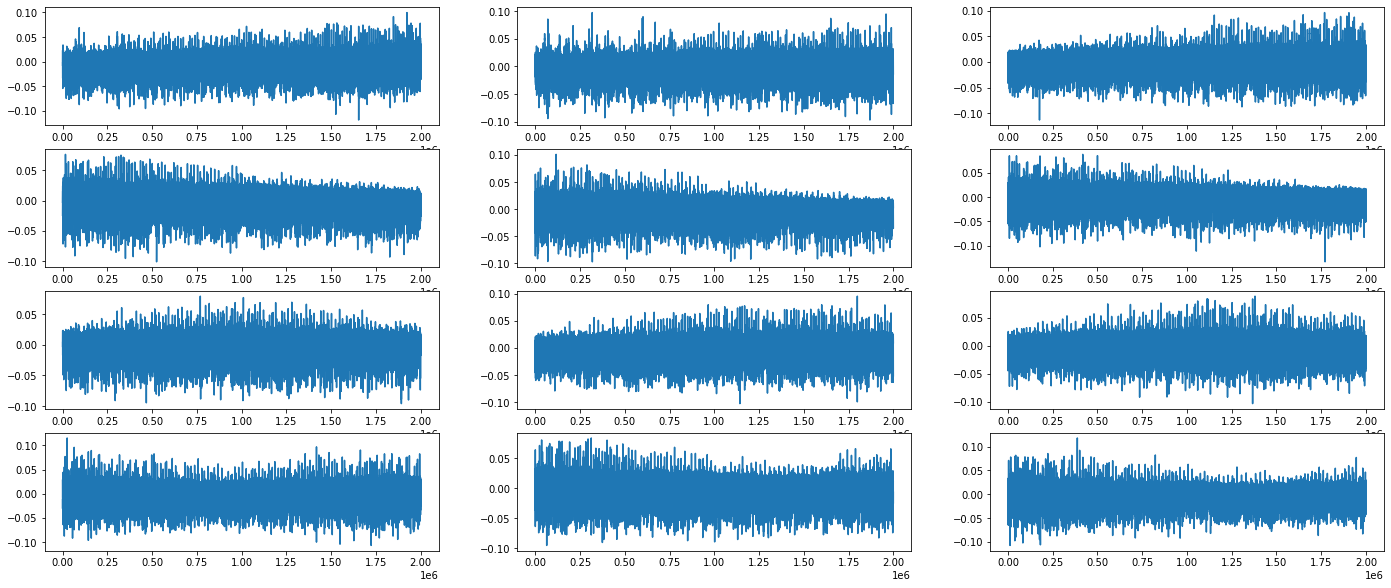

In [ ]:
#outer race fault

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+24])

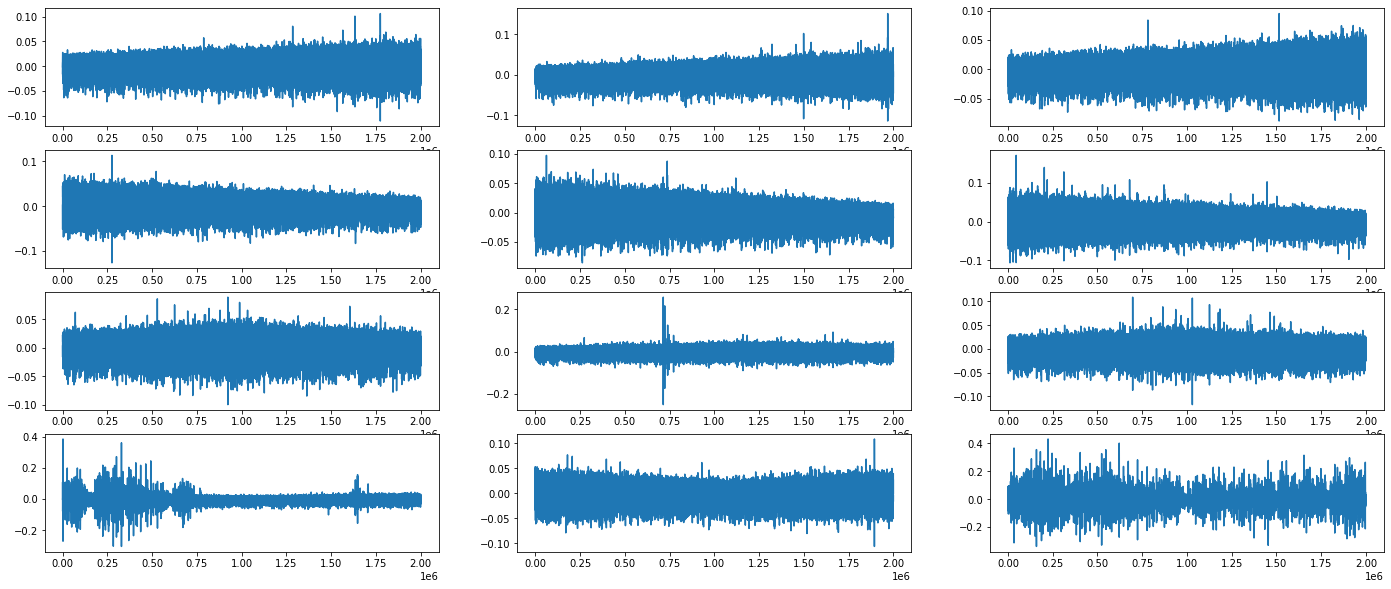

In [ ]:
#ball fault

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+36])

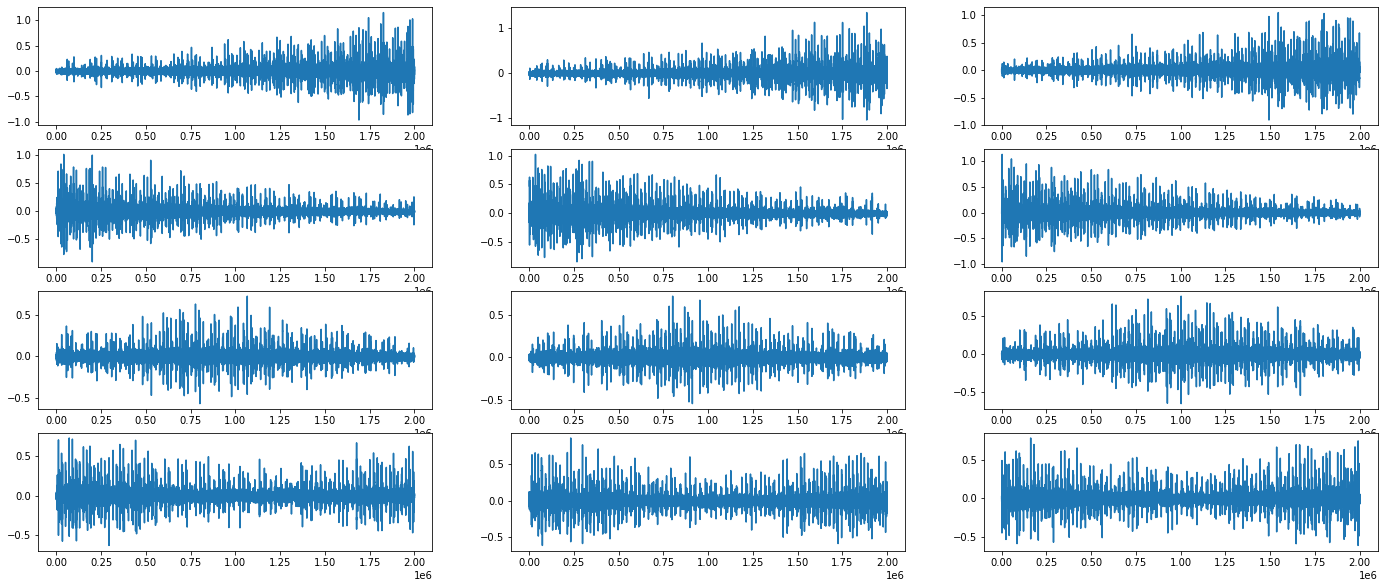

In [ ]:
#combination of faults

plt.figure(figsize=(24,10))
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(range(2000000), raw[i+48])

#### 베어링 상태별 FFT 그래프

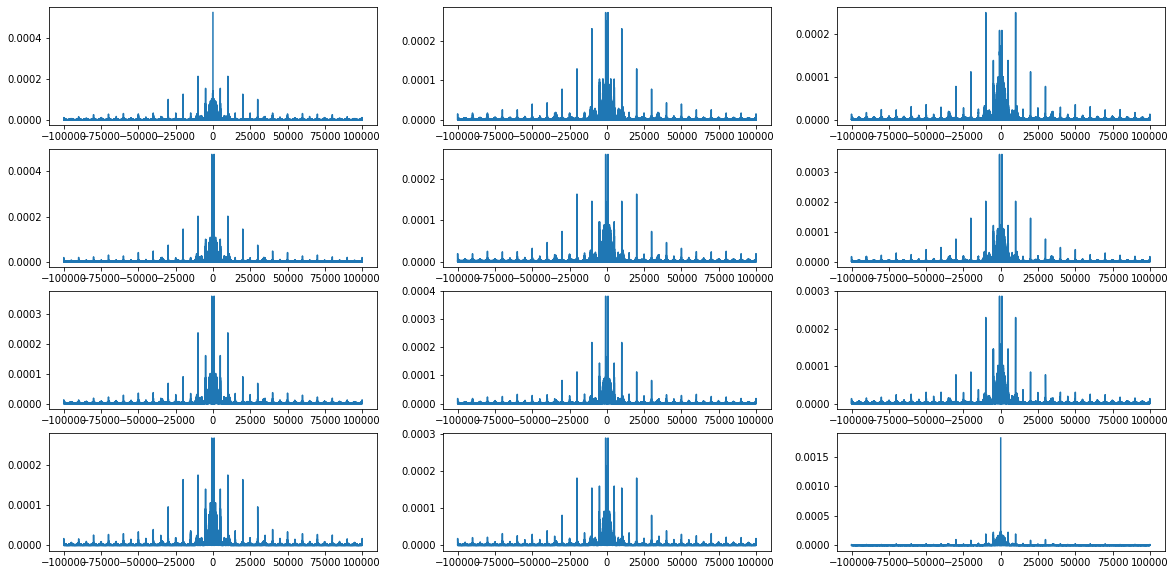

In [ ]:
#healthy bearing

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i]))

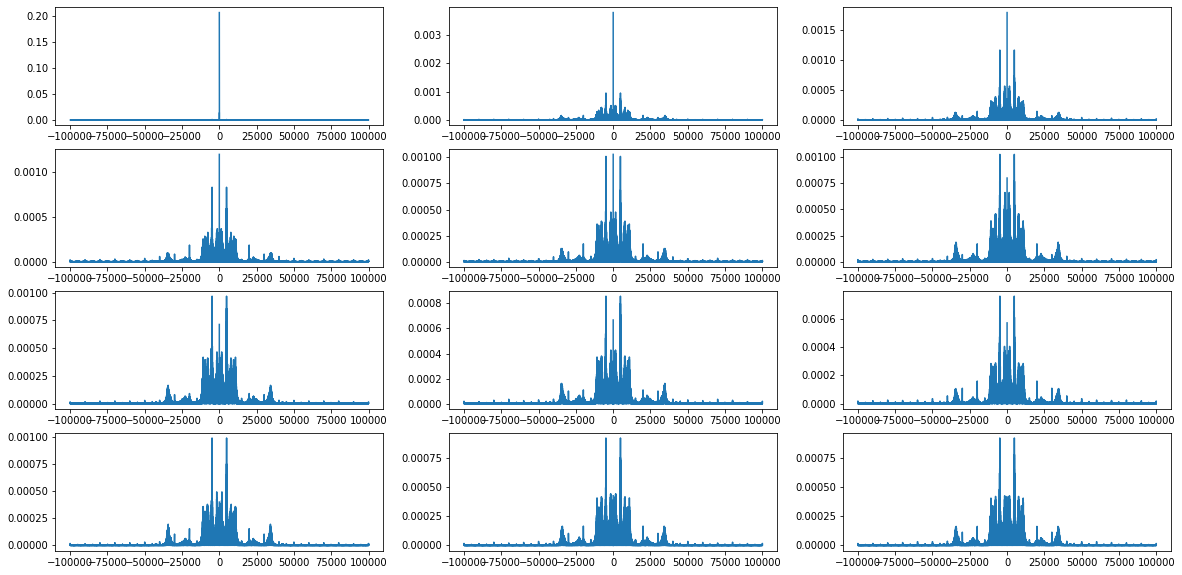

In [ ]:
#inner race fault 

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+12]))

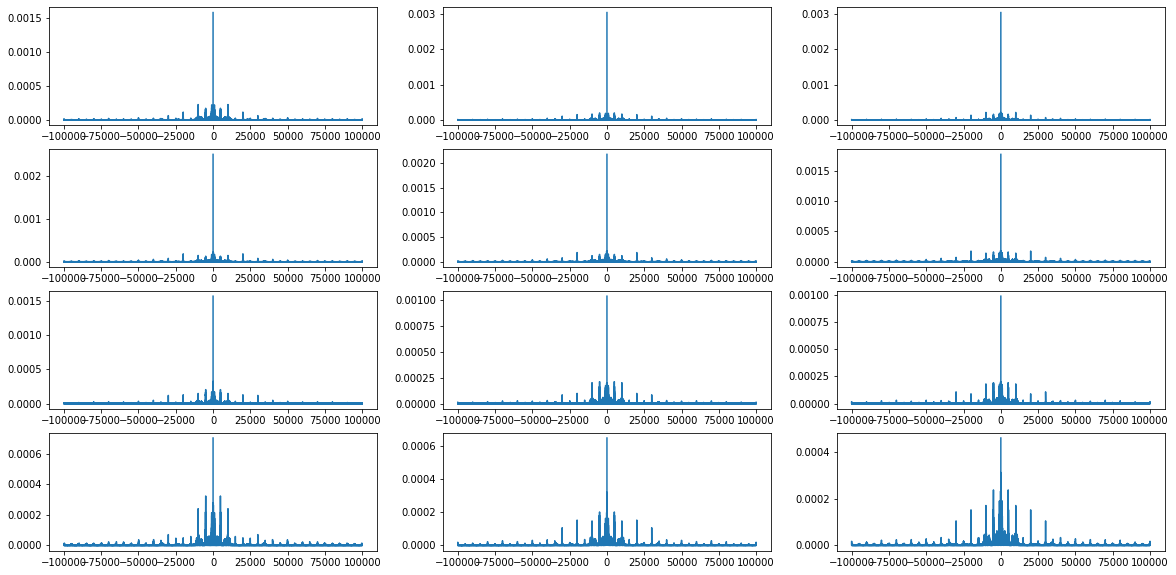

In [ ]:
#outer race fault

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+24]))

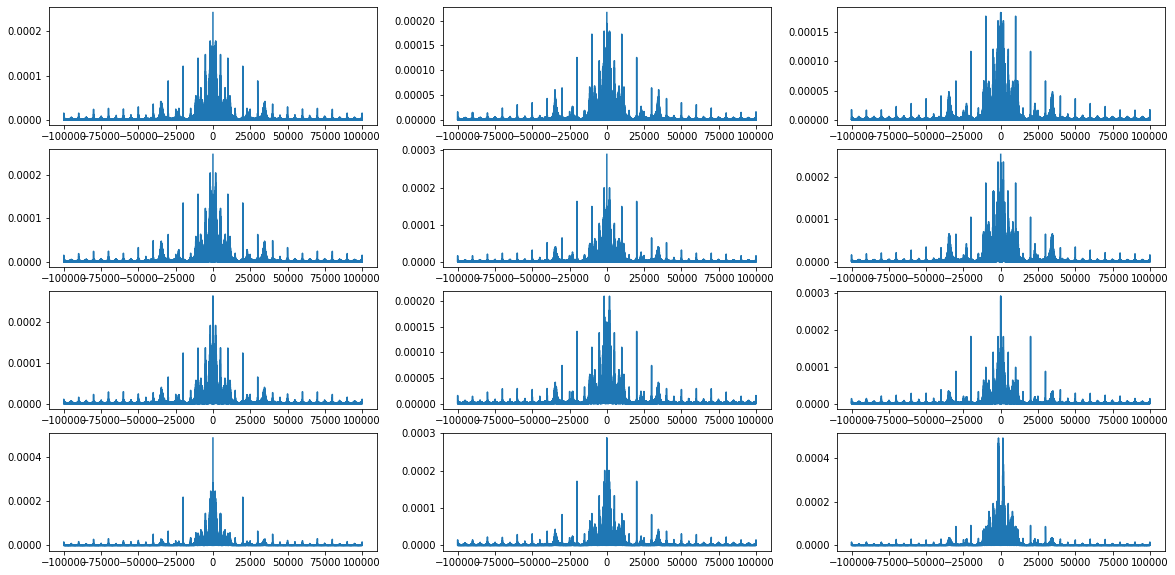

In [ ]:
#ball fault

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+36]))

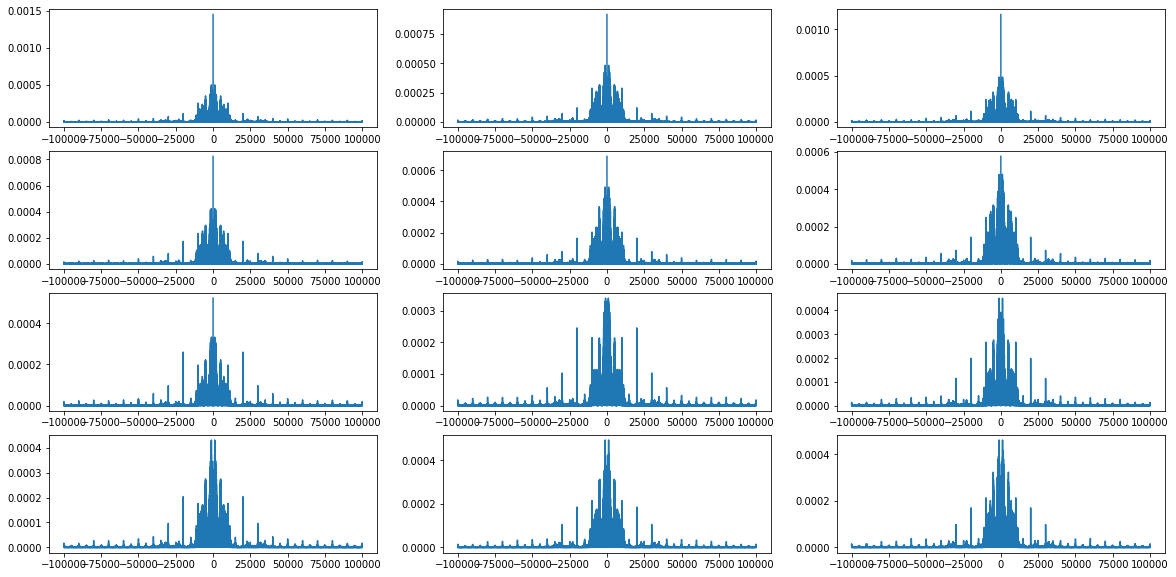

In [ ]:
#combination of faults

plt.figure(figsize=(20,10))
freq=np.fft.fftfreq(N, 1/Fs)
for i in range(12):
  plt.subplot(4,3,i+1)
  plt.plot(freq, abs(raw_fft[i+48]))

#### 베어링 속도별 평균 FFT 그래프

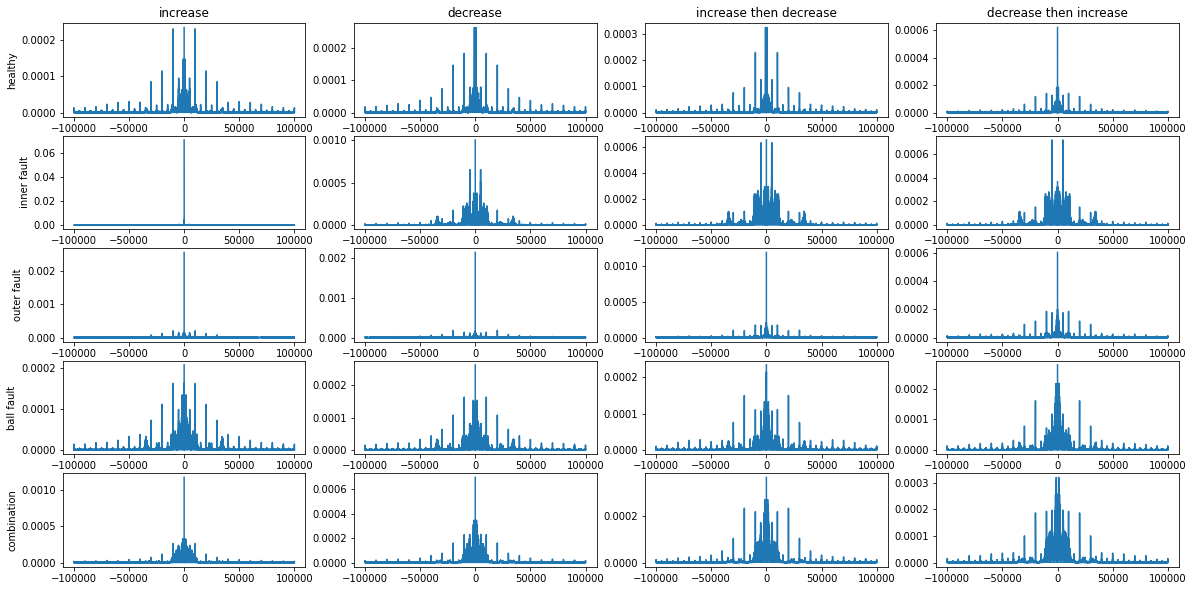

In [ ]:
plt.figure(figsize=(20,10))

for i in range(20):
  plt.subplot(5,4,i+1)
  plt.plot(freq, np.average(abs(raw_fft[3*i:3*(i+1)]), axis=0))

  if i==0: plt.title('increase'); plt.ylabel('healthy')
  elif i==1: plt.title('decrease')
  elif i==2: plt.title('increase then decrease')
  elif i==3: plt.title('decrease then increase')
  elif i==4: plt.ylabel('inner fault')
  elif i==8: plt.ylabel('outer fault')
  elif i==12: plt.ylabel('ball fault')
  elif i==16: plt.ylabel('combination')
  
plt.show()

#### 베어링 속도별 평균 STFT 그래프

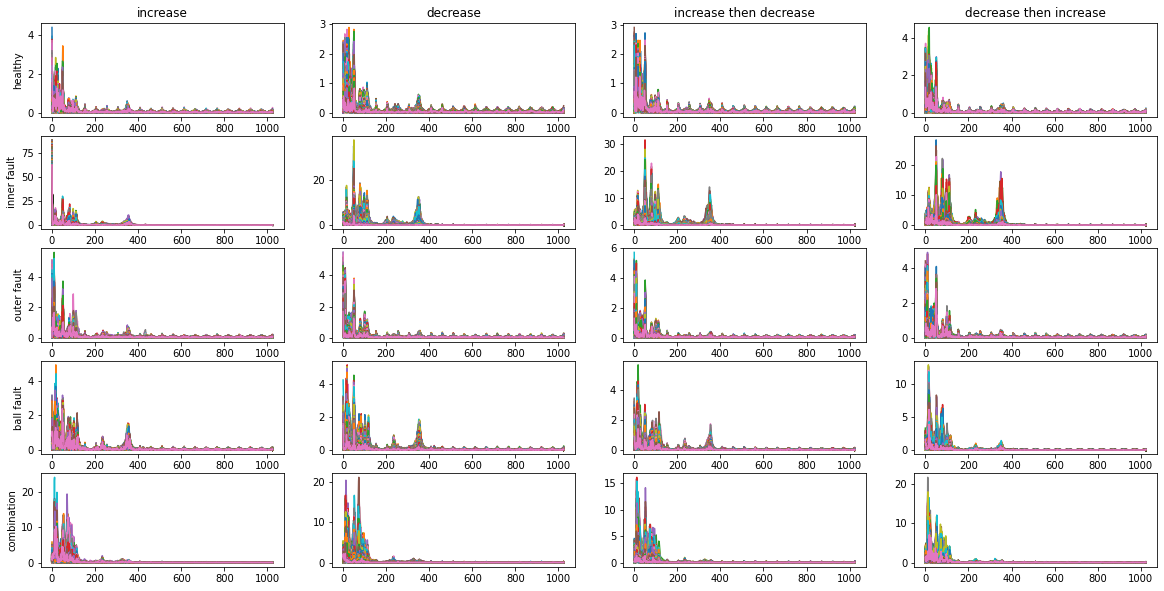

In [ ]:
plt.figure(figsize=(20,10))

for i in range(20):
  plt.subplot(5,4,i+1)
  plt.plot(abs(librosa.stft((np.average(raw[3*i:3*(i+1)], axis=0)))))
  
  if i==0: plt.title('increase'); plt.ylabel('healthy')
  elif i==1: plt.title('decrease')
  elif i==2: plt.title('increase then decrease')
  elif i==3: plt.title('decrease then increase')
  elif i==4: plt.ylabel('inner fault')
  elif i==8: plt.ylabel('outer fault')
  elif i==12: plt.ylabel('ball fault')
  elif i==16: plt.ylabel('combination')
  
plt.show()

## 전에 쓰던 전처리 코드

In [ ]:
#50초 정도 소요
raw=[]
file_names=['H-A-1.mat','H-A-2.mat','H-A-3.mat','H-B-1.mat','H-B-2.mat','H-B-3.mat','H-C-1.mat','H-C-2.mat','H-C-3.mat','H-D-1.mat','H-D-2.mat','H-D-3.mat','I-A-1.mat','I-A-2.mat','I-A-3.mat','I-B-1.mat','I-B-2.mat','I-B-3.mat','I-C-1.mat','I-C-2.mat','I-C-3.mat','I-D-1.mat','I-D-2.mat','I-D-3.mat','O-A-1.mat','O-A-2.mat','O-A-3.mat','O-B-1.mat','O-B-2.mat','O-B-3.mat','O-C-1.mat','O-C-2.mat','O-C-3.mat','O-D-1.mat','O-D-2.mat','O-D-3.mat','B-A-1.mat','B-A-2.mat','B-A-3.mat','B-B-1.mat','B-B-2.mat','B-B-3.mat','B-C-1.mat','B-C-2.mat','B-C-3.mat','B-D-1.mat','B-D-2.mat','B-D-3.mat', 'C-A-1.mat','C-A-2.mat','C-A-3.mat','C-B-1.mat','C-B-2.mat','C-B-3.mat','C-C-1.mat','C-C-2.mat','C-C-3.mat','C-D-1.mat','C-D-2.mat','C-D-3.mat']

for i in range(60):
  mat_file = io.loadmat(file_path+file_names[i])['Channel_1'].reshape(2000000)
  raw.append(mat_file)

raw=np.array(raw)

In [ ]:
#5초 정도 소요
raw_fft=[]

for i in range(60):
  fft=np.fft.fft(raw[i])/N
  raw_fft.append(fft)

raw_fft=np.array(raw_fft)

In [ ]:
raw_100=[]

for i in range(60):
  res=raw[i].reshape(1000,2000)
  for j in range(1000):
    raw_100.append(res[j])

raw_100=np.array(raw_100)

In [ ]:
raw_fft_100=[]

for i in range(60000):
  fft=np.fft.fft(raw_100[i])/2000
  raw_fft_100.append(fft)

raw_fft_100=np.array(raw_fft_100)

## 전에 쓰던 함수

In [ ]:
def show(data):
    plt.figure(figsize=(20,5))
    plt.plot(range(2000000), data)

In [ ]:
def during(data,a,b):
    start=a
    end=b
    new_data=data[int(200000*a):int(200000*b)]

    plt.figure(figsize=(20,5))
    plt.plot(range(int(200000*(b-a))), new_data)
    plt.show()

In [ ]:
def fft(data, n=N):
    time=np.arange(0,10,1/Fs)
    Y=np.fft.fft(data)/N
    Y_mag=np.abs(Y)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.plot(time[:n], data[:n])
    plt.subplot(2,1,2)
    plt.stem(Y_mag[:n])
    plt.show()